<a href="https://colab.research.google.com/github/hjjimmykim/SchwabRoyale/blob/master/SchwabRoyale_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Schwab Royale

In the beginning there was darkness.
Then there was David.

What we have:
1. Multi-team multi-agent battle royale setup where each agent gets personal reward for killing anyone and a shared team reward for killing opponent teams.
2. Basic Q-learning with experience replay and target Q-networks.

Extra features to be implemented: <br>
1. Limited visibility (partial information)
2. Variants in agent types (e.g. healers, necromancers) with different goals (e.g. save rather than kill things).
3. Variance in agent parameters (e.g. selfishness)
4. Different game setups (e.g. free-for-all, KotH)
5. Team reward per capita -> emergence of spite?
6. Communication.

Research Ideas: <br>
1. Something with mean field game theory?
2. Phase transitions in behavior by agent parameters (e.g. selfish psychopath killing its own team members -> defect vs. coop. a la game theory?).
3. Emergent language. Different dialects forming within different teams? If you allow them to overhear each other, do they develop encryption/decryption?
4. How to deal with sparse rewards? Curiosity-driven learning, options, etc.?
5. Active learning (e.g. pick experiences from experience replay where something interesting happens)
6. Curriculum learning (e.g. start from easier scenarios like where everyone's next to each other -> learns that killing peope gives you rewards and then move on to harder scenarios where everyone's farther apart -> have to learn to get closer to each other to reduce the problem to what was already learned)
7. Metacontroller ("Overmind") per each team that tunes each team member's hyperparameters.

# Libraries

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from IPython import display # For animation

import time # Keeping track of time
import copy

from collections import deque

# Machine learning
import tensorflow as tf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of PIL.Image failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name 'py3'
]
[autoreload of PIL._binary failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name 'py3'
]


# Parameters

In [0]:
# Agent parameters
K = 2           # Number of teams
N = 2           # Number of agents per team
hp_start = 2    # Starting hp
action_size = 4 # Four cardinal directions

# Simulation parameters
M = 8    # Width of map
max_turn = 10000 # Maximum number of turns per episode
record_turn = int(max_turn/100) # Record time every record_turn turns
n_ep = 2  # Number of training episodes (games)

# Reinforcement learning parameters
batch_size = 10 # Batch size
memory_size = 100 # Number of experiences agent can keep
hidden_dim = 10 # Hidden layer size

target_copy_freq = 10 # Update the target network every this many turns

alpha = 0.01 # Learning rate
beta = 0.1   # Exploitation parameter
gamma = 0.9  # Discount factor
sigma = 0.5  # Selfishness factor
Omega = N    # Final survivor bonus (should it be for team and/or self?)

#Spunk

Constantijn takes responsibility for the time wasted making this, however, Jimmy supported him.

In [0]:
death_messages = ["was wasted by",
                  "met a bitter end at the hands of",
                  "was swarmed by TensorBros sent by",
                  "was forced to press Alt+F4 by",
                  "was peer-reviewed by",
                  "got schwabbed by", # https://www.urbandictionary.com/define.php?term=Schwabbed
                  "was brutally neglected by",
                  "had his heart stolen by",
                  "slipped and fell while running from",
                  "became petrified by the sight of",
                  "wished Asimov protected him against",
                  "was denied cluster access by"
                 ]

def kill_log(killer, killer_team, victim, victim_team, turn):
  phrase = "%s [Team %i] " + np.random.choice(death_messages) + " %s [Team %i] on turn %i."
  return phrase % ("David "+str(victim), victim_team, "David "+str(killer), killer_team, turn)

def kill_log_straw(killer, killer_team, victim, victim_team, turn):
  phrase = "%s [Team %i] " + np.random.choice(death_messages) + " %s [Team %i] on turn %i."
  return phrase % ("Straw Man "+str(victim), victim_team, "Straw Man "+str(killer), killer_team, turn)

# Neural Network

References:
*   https://web.stanford.edu/class/cs20si/2017/lectures/slides_14.pdf
*   https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Deep%20Q%20Learning/Doom/Deep%20Q%20learning%20with%20Doom.ipynb



In [0]:
class Net:
  def __init__(self, input_dim, hidden_dim = 100, output_dim = 4, name="brain_name"):
    # Fully-connected feedforward network with 2 hidden layers    
    # input-dim = 1-D reshaped map + hp
    # hidden_dim = number of units per hidden layer
    # output_dim = number of outputs (i.e. actions)

    # Input placeholder
    self.inputs = tf.placeholder(tf.float32, shape=[None,input_dim], name="inputs")

    ## Weight initialization
    # input -> h1
    W0 = tf.Variable(tf.truncated_normal([input_dim,hidden_dim],stddev=0.1), name=name)
    b0 = tf.Variable(tf.constant(0.1,shape=[hidden_dim]), name=name)

    # h1 -> h2
    W1 = tf.Variable(tf.truncated_normal([hidden_dim,hidden_dim],stddev=0.1), name=name)
    b1 = tf.Variable(tf.constant(0.1,shape=[hidden_dim]), name=name)
    
    # h2 -> output
    W2 = tf.Variable(tf.truncated_normal([hidden_dim,output_dim],stddev=0.1), name=name)
    b2 = tf.Variable(tf.constant(0.1,shape=[output_dim]), name=name)
    
    
    ## Hidden layers
    h1 = tf.nn.relu(tf.matmul(self.inputs,W0) + b0)
    h2 = tf.nn.relu(tf.matmul(h1,W1) + b1)
    
    ## Output layer
    self.outputs = tf.matmul(h2,W2) + b2
    
    ## Keep track of parameters
    self.params = [W0,b0,W1,b1,W2,b2]
    
    
    #Learnability
    self.actions = tf.placeholder(tf.int32, shape=[None, 1], name="actions")
    idx = tf.stack([tf.range(tf.shape(self.actions)[0]),self.actions[:,0]],axis=1) # Indices to gather; of form [[0,actions[0]],[1,actions[1]], ...]
    
    self.Q = tf.gather_nd(self.outputs,idx) # Pick out q-values corresponding to selected actions

    self.target_Q = tf.placeholder(tf.float32, shape=[None, 1])
    
    self.loss = tf.reduce_mean(tf.square(self.target_Q - self.Q))    
    self.optimizer = tf.train.AdamOptimizer(alpha).minimize(self.loss)

Memory Class source: https://github.com/udacity/deep-learning/blob/master/reinforcement/Q-learning-cart.ipynb

In [0]:
class Memory:
  def __init__(self, max_size):
    self.max = max_size
    self.buffer = deque(maxlen = max_size)    # "deque" = Double Ended QUEue
  
  # Add entry. FIFO.
  def add(self, experience):
    self.buffer.append(experience)
  
  # Sample batch_size number of entries, without replacement. Return as a list.
  def sample(self, batch_size):
    buffer_size = len(self.buffer)

    index = np.random.choice(np.arange(buffer_size),
                             size = min(batch_size,buffer_size),
                             replace = False)
    return [self.buffer[i] for i in index]
  
  # Own additions
  def is_full(self):
    return len(self.buffer) == self.max
  
  def wipe(self):
    self.buffer.clear() # NB, does not affect max length

  def length(self):
    return len(self.buffer)

### Stanford fancy memory alternative:

In [0]:
class ReplayBuffer:
  
  def __init__(self, template, capacity):
    self._capacity = capacity # Number of memories to maintain
    self._buffers = self._create_buffers(template)
    self._index = tf.Variable(0, dtype=tf.int32, trainable=False)
    
  # Number of memories saved
  def size(self):
    return tf.minimum(self._index, self._capacity)
  
  def append(self, tensors):
    position = tf.mod(self._index, self._capacity)
    with tf.control_dependencies([
        b[position].assign(t) for b, t in
        zip(self._buffers, tensors)]):
      return self._index.assign_add(1)
  
  def sample(self, amount):
    positions = tf.random_uniform((amount,), 0, self.size - 1, tf.int32)
    return [tf.gather(b, positions)
            for b in self._buffers]

  def _create_buffers(self, template):
    buffers = []
    for tensor in template:
      shape = tf.TensorShape([self._capacity]).concatenate(
          tensor.get_shape())
      initial = tf.zeros(shape, tensor.dtype)
      buffers.append(tf.Variable(
          initial, trainable=False))
    return buffers

# Agent

In [0]:
class Agent:
  def __init__(self, id, hp, loc, k, memory_size, tenure):
    self.id = id    # Agent id (in agent_dict)
    self.hp = hp    # Hit points
    self.loc = loc  # Location (r,c coordinate [r,c])
    self.team = k   # Team index (k = 1, ..., K), since 0 is self!
    self.memory_size = memory_size # Experience replay maximum capacity
    self.tenure = tenure       # If you don't have tenure yet, you gotta learn (i.e. determines whether the agent is learning)
    
    self.personal_reward = 0   # Keep track of personal reward    
    
    # Create brain
    input_dim = M*M + 1 # Map cells + hp
    output_dim = action_size
    
    self.DQN = Net(input_dim, hidden_dim, output_dim, name="Q_primary"+str(id)) # Personal neural network
    self.DQN_target = Net(input_dim, hidden_dim, output_dim, name="Q_target"+str(id))         # Target network
    
    self.memory = Memory(memory_size) # Experience replay
    
  
  # Checks living status
  def alive(self):
    return self.hp > 0

  # State formation
  def observe(self, map):
    state = copy.deepcopy(map)
    state[self.loc[0]][self.loc[1]] = 0            # Own location = 0 on map
    state = np.reshape(state, [1,-1]).squeeze()    # Convert to 1D array
    state = np.hstack([state, self.hp])            # Append hp
    return state
  '''
  # Takes a state, and returns an action from the action space
  def choose_action(self, state, sess):
    # Action selection (Q function) ------------------------------------------
    q_values = self.DQN(state) # Get q-values from the network
    p_values = tf.exp(beta * q_values)/tf.reduce_sum(tf.exp(beta * q_values)) # Boltzmann probabilities
    
    action = np.random.choice(np.arange(4),p=p_values.eval())
    return action
  '''
  
  # Taking an action based on chosen direction
  def act(self, dir, turn, quiet):
    # dir should be an np.array
    # turn = just for displaying kill message
    # quiet = print kill message or not
    
    # Rewards resulting from this move
    personal_point = 0
    team_point = 0
    
    target_loc = self.loc + dir # Candidate target location
    
    # Check if target location is within bounds (make sure the agent cannot move into itself)
    if check_valid_loc(target_loc):
      
      target_ind = map[target_loc[0]][target_loc[1]]    # Object at target location
      
      if target_ind == -1:                              # If target location is empty
        map[self.loc[0],self.loc[1]] = -1               # Previous location becomes empty
        map[target_loc[0],target_loc[1]] = self.team    # Target location becomes occupied
        self.loc = target_loc                           # Update location
      else:                                             # If target location is occupied
        # Agent at target location
        target_id = find_agent(target_loc)
        target_agent = agent_dict[target_id]
        '''
        if not target_agent.alive(): # Target agent is already dead; this should not run
          print("David", self.id, "teabagged David", target_id)
        '''
        target_agent.hp -= 1                            # Deal damage

        if not target_agent.alive():                    # If target agent has been killed
          # Display kill log
          if not quiet:
            print(kill_log(self.id, self.team, target_id, target_agent.team, turn))

          target_agent.loc = [-1,-1]                    # Move corpse to the underworld

          map[self.loc[0],self.loc[1]] = -1             # Previous location becomes empty
          map[target_loc[0],target_loc[1]] = self.team  # Target location becomes occupied
          self.loc = target_loc                         # Update location
          
          personal_point += 1             # Gain a point for self
          if target_agent.team != self.team:
            team_point += 1               # Gain a point for the team, if the target was from another team
  
    # Update the cumulative rewards
    self.personal_reward += personal_point
    team_scores[self.team-1] += team_point
    
    # Return immediate rewards
    return personal_point, team_point

In [0]:
class Straw_Man:
  def __init__(self, id, hp, loc, k):
    self.id = id    # Agent id (in agent_dict)
    self.hp = hp    # Hit points
    self.loc = loc  # Location (r,c coordinate [r,c])
    self.team = k   # Team index (k = 1, ..., K), since 0 is self!
    
    self.p_values = []
    self.p_values = np.exp(beta * np.random.normal(0,1, [1,4]))
    self.p_values = self.p_values/np.sum(self.p_values)
    
  
  # Checks living status
  def alive(self):
    return self.hp > 0

  
  # Taking an action based on chosen direction
  def Boltz_act(self):
    
    action = np.random.choice(np.arange(4),p=np.squeeze(self.p_values))
    
    target_loc = self.loc + get_dir(action) # Candidate target location
    
    # Check if target location is within bounds (make sure the agent cannot move into itself)
    if check_valid_loc(target_loc):
      
      target_ind = map[target_loc[0]][target_loc[1]]    # Object at target location
      
      if target_ind == -1:                              # If target location is empty
        map[self.loc[0],self.loc[1]] = -1               # Previous location becomes empty
        map[target_loc[0],target_loc[1]] = self.team    # Target location becomes occupied
        self.loc = target_loc                           # Update location
      else:                                             # If target location is occupied
        # Agent at target location
        target_id = find_agent(target_loc)
        target_agent = agent_dict[target_id]
        
        target_agent.hp -= 1                            # Deal damage

        if not target_agent.alive():                    # If target agent has been killed
          # Display kill log
          print(kill_log_straw(self.id, self.team, target_id, target_agent.team, turn))

          target_agent.loc = [-1,-1]                    # Move corpse to the underworld

          map[self.loc[0],self.loc[1]] = -1             # Previous location becomes empty
          map[target_loc[0],target_loc[1]] = self.team  # Target location becomes occupied
          self.loc = target_loc                         # Update location

## Agent Testing

N.B.: Before testing agent features, run Initialize below

###Movement Testing

Test whether movement is recorded on the map properly, 
test agent's functions

In [0]:
initialize_map()
test_agent = agent_dict[0]

NameError: ignored

In [0]:
agent_dict

{0: <__main__.Agent at 0x7f42fdccefd0>,
 1: <__main__.Agent at 0x7f42fdcce668>,
 2: <__main__.Agent at 0x7f42fdc90940>,
 3: <__main__.Agent at 0x7f42fdc905c0>}

In [0]:
print(test_agent.loc)
test_agent.observe()

[0 0]


array([[ 0, -1,  1, -1, -1],
       [-1, -1, -1, -1, -1],
       [ 2, -1,  2, -1, -1],
       [-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1]])

In [0]:
test_agent.move([1,1])
print(test_agent.loc)
test_agent.observe()

[1 1]


array([[-1, -1,  1, -1, -1],
       [-1,  0, -1, -1, -1],
       [ 2, -1,  2, -1, -1],
       [-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1]])

In [0]:
test_agent.move([0,-1])
print(test_agent.loc)
test_agent.observe()

[1 0]


array([[-1, -1,  1, -1, -1],
       [ 0, -1, -1, -1, -1],
       [ 2, -1,  2, -1, -1],
       [-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1]])

In [0]:
test_agent.move([-1,0])
print(test_agent.loc)
test_agent.observe()

[0 0]


array([[ 0, -1,  1, -1, -1],
       [-1, -1, -1, -1, -1],
       [ 2, -1,  2, -1, -1],
       [-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1]])

In [0]:
find_agent([0,0])

0

### Combat Testing

Test attacking (movement upon kill), HP tracking, death of a teammate (personal reward), and death of an enemy (personal and team reward)

In [0]:
initialize_map()
attack_agent = agent_dict[0]
gimp_agent = agent_dict[1]
enemy_agent = agent_dict[3]

In [0]:
print("Attacker's HP:", attack_agent.hp)
print("Gimp's HP:", gimp_agent.hp)
print("Attacker's Score:", attack_agent.reward)    # Just to check it's well-behaved
print("Team Scores", team_scores)
attack_agent.observe()

Attacker's HP: 2
Gimp's HP: 2
Attacker's Score: 0
Team Scores [0 0]


array([[ 0, -1,  1, -1, -1],
       [-1, -1, -1, -1, -1],
       [ 2, -1,  2, -1, -1],
       [-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1]])

In [0]:
attack_agent.move([0,2])
print("Gimp's HP:", gimp_agent.hp)
print("Attacker's Score:", attack_agent.reward)
print("Team Scores", team_scores)
attack_agent.observe()

Gimp's HP: 1
Attacker's Score: 0
Team Scores [0 0]


array([[ 0, -1,  1, -1, -1],
       [-1, -1, -1, -1, -1],
       [ 2, -1,  2, -1, -1],
       [-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1]])

In [0]:
attack_agent.move([0,2])
print("Gimp's HP:", gimp_agent.hp)
print("Attacker's Score:", attack_agent.reward)
print("Team Scores", team_scores)
attack_agent.observe()

Gimp's HP: 0
Attacker's Score: 1
Team Scores [0 0]


array([[-1, -1,  0, -1, -1],
       [-1, -1, -1, -1, -1],
       [ 2, -1,  2, -1, -1],
       [-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1]])

In [0]:
attack_agent.move([2,0])
attack_agent.move([2,0])
print("Enemy's HP:", enemy_agent.hp)
print("Attacker's Score:", attack_agent.reward)
print("Team Scores", team_scores)
attack_agent.observe()

Enemy's HP: 0
Attacker's Score: 2
Team Scores [1 0]


array([[-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1],
       [ 2, -1,  0, -1, -1],
       [-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1]])

In [0]:
agent_dict

{0: <__main__.Agent at 0x7f42fdc64630>, 2: <__main__.Agent at 0x7f42fdc645c0>}

# Functions

In [0]:
# Schwifty Functions
# Check if the given location is within bounds
def check_valid_loc(loc):
  return (np.all(0 <= loc) and np.all(loc < M))

# Find the agent at a given location
def find_agent(loc):
  for ind, agnt in agent_dict.items(): # Loop through all agents
    if np.all(agnt.loc == loc): # Return the index of agent at the location
      return ind
    
# Translates action space to a direction
def get_dir(action):
  # NESW
  dir_list = [np.array([-1,0]),np.array([0,1]),np.array([1,0]),np.array([0,-1])]
  return dir_list[action]

# Initialize map, agents, and team scores
def initialize():
  agent_dict = {}                            # Dictionary of all agents
  map = -np.ones([M,M],dtype=np.int)         # M x M map
  team_scores = np.zeros(K, dtype=np.int)    # Team scores
  
  for k in range(1, K+1):    # Loop through teams
    for n in range(N):       # Loop through agents per team
      id = N*(k-1) + n                                   # Agent id
      loc = np.array([int(M/K)*(k-1),int(M/N)*n])        # Starting location
  
      agent_dict[id] = Agent(id, hp_start, loc, k, memory_size, False) # Create agent object and put it in the dictionary
      map[loc[0],loc[1]] = k                              # Record it on the map by its team number
      agent_dict[id].memory.wipe()                        # Reset memory
      
  return map, agent_dict, team_scores

# Reset map and team scores, preserve agents
def reset(agent_dict):
  map = -np.ones([M,M],dtype=np.int)         # M x M map
  team_scores = np.zeros(K, dtype=np.int)

  for k in range(1, K+1):   # Loop through teams
    for n in range(N):      # Loop through agents per team
      agnt = agent_dict[N*(k-1) + n] # Take agent
      
      loc = np.array([int(M/K)*(k-1),int(M/N)*n])       # Spawn location
      agnt.loc = loc     # Respawn
      agnt.hp = hp_start # Revive
      map[loc[0],loc[1]] = agnt.team    # Record on the map
            
  return map, team_scores


# Return queue of surviving agents (the order in which they will act)
def action_queue(agent_dict):
  queue = []

  for ind, agnt in agent_dict.items(): # Loop through all agents
    if agnt.alive():                   # Only include the living
      queue.append(ind)

  np.random.shuffle(queue)               # Random shuffle
  
  return queue

## Visualization

In [0]:
def plot_map(map):
  # Set background
  map_plot = copy.deepcopy(map)
  map_plot[map_plot == -1] = 8 # Color the background
  
  # Show map
  plt.imshow(map_plot, cmap='Set1',interpolation='none',aspect='equal')

  # Current axis
  ax = plt.gca()

  # Set up grid
  ax.set_xticks(np.arange(-0.5,M,1));
  ax.set_yticks(np.arange(-0.5,M,1));

  ax.set_xticklabels([]);
  ax.set_yticklabels([]);

  # Show grid
  plt.grid(color='w')
  
  # Display
  display.display(plt.gcf())
  display.clear_output(wait=True)

## Stats

In [0]:
# Returns a Dictionary of Agent IDs and their HPs
def hp_dict():
  hps = {}
  for in, agnt in agent_dict.items():
    hps[ind] = agnt.hp
  return hps

# Returns a Dictionary of Agent IDs and their HPs
def reward_dict():
  rewards = {}
  for in, agnt in agent_dict.items():
    rewards[ind] = agnt.personal_reward
  return rewards

# Initialize

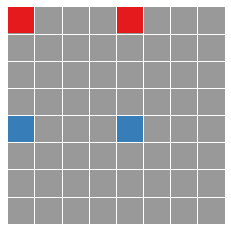

In [0]:
# map = M x M grid where each site has -1 for empty space or the team number of the occupying agent
# agent_dict = dictionary of all agents (initialized, then untouched); 

tf.reset_default_graph() # Reset variables
map, agent_dict, team_scores = initialize()
plot_map(map)

# Simulation

## Pre-populating memory

Do we want pretrain length as a variable input? Right now it's just to fill one batch

In [0]:
map, team_scores = reset(agent_dict)

# Returns true if all experience replays are at max capacity.
def full_mem():
  all_clear = True
  for ind, agnt in agent_dict.items():
    if not agnt.memory.is_full():
      all_clear = False
  return all_clear
    
prepop_turn = 1
agents_to_go_list = []
while prepop_turn < 15000: #not full_mem():
  turn_queue = []
  for ind, agnt in agent_dict.items():
    if agnt.alive() and not agnt.memory.is_full():
      turn_queue.append(ind)
  np.random.shuffle(turn_queue)
  
  if prepop_turn % 1000 == 0:
    print("----Populating memory, turn", prepop_turn, "----")
    agents_to_go_list = []
    for ind, agnt in agent_dict.items():
      if not agnt.memory.is_full():
        agents_to_go_list.append(ind)
    print("Agents to go:", len(agents_to_go_list))
    map, team_scores = reset(agent_dict)

  # Reset map if there is one survivor
  if len(turn_queue) <= 1:
    print("End game, resetting map")
    map, team_scores = reset(agent_dict)
    continue
  
  # Loop through alive and non-memory-saturated agents
  for j in turn_queue:   
    # Agent object
    current_agent = agent_dict[j]

    # If already dead, pass turn.
    if not current_agent.alive():
      continue;

    # State formation
    state = current_agent.observe(map)

    # Action selection
    action = np.random.choice(4)    
    if action == 0:                 # North
      dir = np.array([-1,0])
    elif action == 1:               # East
      dir = np.array([0,1])
    elif action == 2:               # West
      dir = np.array([0,-1])
    elif action  == 3:              # South
      dir = np.array([1,0])

    # Take the action
    personal_point,team_point = current_agent.act(dir,prepop_turn, False)

    # New state
    state_new = current_agent.observe(map)

    # Immediate reward
    reward = sigma * personal_point + (1-sigma) * team_point # Should team point sum over all team members?
    
    # Add experience to memory: [s,a,r,s']
    current_agent.memory.add((state, action, reward, state_new))
  
  prepop_turn += 1

print("Memory Population took", prepop_turn, "turns.")

In [0]:
for ind, agnt in agent_dict.items():
  print(agnt.memory.length())

45
45
43
45


## Training

In [0]:
# np.random.seed(1)

# Training
sess = tf.InteractiveSession() # Initialize session
sess.run(tf.global_variables_initializer())

for i_ep in range(n_ep): # Loop through games
  
  # Reset map and team scores
  map, team_scores = reset(agent_dict)
  
  print('Game', i_ep, 'started.')
  # For keeping track of time
  t_start = time.time()
  t1 = time.time()
  for turn in range(max_turn):
    turn_queue = action_queue(agent_dict) # Order of taking actions this turn

    # End of game (last man standing)
    if len(turn_queue) == 1:
      print("David", turn_queue[0], "is the lone survivor.")
      print("Team Scores:", team_scores)
      print("Game", i_ep, "ended on turn", turn-1)#, "-----------------------")
      break
    
    # Target q network update
    if turn % target_copy_freq:
      for ind, agnt in agent_dict.items():
        # Get all the variables in the Q primary network.
        q_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="Q_primary"+str(ind))
        # Get all the variables in the Q target network.
        q_target_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="Q_target"+str(ind))
        assert len(q_vars) == len(q_target_vars)

        # Hard update
        sess.run([v_t.assign(v) for v_t, v in zip(q_target_vars, q_vars)])


    # Loop through alive agents
    for j in turn_queue:
      # Agent object
      current_agent = agent_dict[j]
      
      # If dead in queue, pass turn.
      if not current_agent.alive():
        continue;

      state = current_agent.observe(map)    # State formation
      
      # Action selection
      q_values = sess.run(current_agent.DQN.outputs,
                          feed_dict = {current_agent.DQN.inputs:np.reshape(state,[1, state.size])}) # Get q-values from the network
      p_values = tf.exp(beta * q_values)/tf.reduce_sum(tf.exp(beta * q_values)) # Boltzmann probabilities
      action = np.random.choice(np.arange(4),p=np.squeeze(p_values.eval()))

      dir = get_dir(action) # Convert to direction

      # Take the action
      personal_point,team_point = current_agent.act(dir, turn, quiet=False)
      
      # New state
      state_new = current_agent.observe(map)

      # Immediate reward
      reward = sigma * personal_point + (1-sigma) * team_point
      
      # Add experience to memory: [s,a,r,s']
      current_agent.memory.add([state, action, reward, state_new])

      # Update Q-function
      if not current_agent.tenure:
        batch = current_agent.memory.sample(batch_size)
        actual_batch_size = len(batch)

        # Separate out s,a,r,s' from the batch which is a list of lists
        states = np.array([item[0] for item in batch])
        actions = np.array([item[1] for item in batch])
        rewards = np.array([item[2] for item in batch])
        next_states = np.array([item[3] for item in batch])

        # Reshape (-1 automatically determines the appropriate length)
        states = np.reshape(states,[actual_batch_size, -1])
        actions = np.reshape(actions,[actual_batch_size, -1])
        rewards = np.reshape(rewards,[actual_batch_size, -1])
        next_states = np.reshape(next_states,[actual_batch_size, -1])
        
        # Q-value of the next state
        Q_next = sess.run(current_agent.DQN_target.outputs,
                          feed_dict = {current_agent.DQN_target.inputs:next_states})
        Q_next_max = np.max(Q_next,axis=1,keepdims=True) # We want to apply np.max() to Q_next
        
        target_Qs = rewards + gamma * Q_next_max
        '''
        loss, _ = sess.run([current_agent.DQN.loss, current_agent.DQN.optimizer],
                            feed_dict={current_agent.DQN.inputs: states,
                                       current_agent.DQN.target_Q: target_Qs,
                                       current_agent.DQN.actions: actions})
        '''
        '''
        # Write TF Summaries
        summary = sess.run(write_op, feed_dict={current_agent.DQN.inputs: states,
                                           current_agent.DQN.target_Q: target_Qs
                                           current_agent.DQN.actions: actions})
        writer.add_summary(summary, i_ep)
        writer.flush()
        '''
    
    # Graphics -----------------------------------------------------------------
    #print("Game " + str(i_ep) + ", turn " + str(turn))
    #plot_map(map)
    #time.sleep(1)
    
    # Time-keeping
    if (turn+1) % record_turn == 0:
      t2 = time.time()
      print("Runtime for turns ", turn-record_turn+1, '-', turn, ': ', t2-t1)
      t1 = t2
    
    # Game ended without conclusion
    if turn == max_turn-1:
      print("Game did not finish.")

  t_finish = time.time()
  print("Game", i_ep, "runtime:", t_finish-t_start, "-----------------------")
  #print("Game", str(i_ep), "ended on turn", turn, "-----------------------")
    
sess.close() # Close session

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Game 0 started.
David 1 [Team 1] became petrified by the sight of David 3 [Team 2] on turn 12.
David 3 [Team 2] was forced to press Alt+F4 by David 0 [Team 1] on turn 27.
David 0 [Team 1] became petrified by the sight of David 2 [Team 2] on turn 51.
David 2 is the lone survivor.
Team Scores: [1 2]
Game 0 ended on turn 51
Game 0 runtime: 54.95929956436157 -----------------------
Game 1 started.
David 3 [Team 2] became petrified by the sight of David 0 [Team 1] on turn 52.
David 0 [Team 1] wished Asimov protected him against David 2 [Team 2] on turn 57.
David 2 [Team 2] was forced to press Alt+F4 by David 1 [Team 1] on turn 60.
David 1 is the lone survivor.
Team Scores: [2 1]
Game 1 ended on turn 60
Game 1 runtime: 210.7058458328247 -----------------------


In [0]:
sess.close() # Close session

## Simulation Logs

64x64 Map, no memory pre-pop

Game 0 started.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in less

Runtime for turns -1-99: 19.63226890563965 \
Runtime for turns 99-199: 47.99417972564697 \
Runtime for turns 199-299: 73.44285726547241 \
Runtime for turns 299-399: 96.52594542503357 \
Runtime for turns 399-499: 125.12971711158752 \
David 3 [Team 2] was swarmed by TensorBros sent by David 1 [Team 1] on turn 568. \
Runtime for turns 499-599: 141.28560543060303 \
Runtime for turns 599-699: 133.77734112739563 \
Runtime for turns 699-799: 149.01863932609558 \
Runtime for turns 799-899: 168.26699447631836 \
Runtime for turns 899-999: 186.9345932006836 \
Runtime for turns 999-1099: 205.70333528518677 \
Runtime for turns 1099-1199: 226.33908247947693 \
Runtime for turns 1199-1299: 244.9416298866272 \
Runtime for turns 1299-1399: 272.72797417640686 \
Runtime for turns 1399-1499: 292.31664848327637 \
Runtime for turns 1499-1599: 306.8765859603882 \
Runtime for turns 1599-1699: 328.33499789237976 \
Runtime for turns 1699-1799: 351.12477588653564

8x8 Map, mem pre-pop

Game 0 started. \
David 0 [Team 1] was forced to press Alt+F4 by David 2 [Team 2] on turn 4. \
David 2 [Team 2] was peer-reviewed by David 3 [Team 2] on turn 31. \
Runtime for turns 0-99: 365.72678685188293 \
David 3 [Team 2] was peer-reviewed by David 1 [Team 1] on turn 129. \
David 1 is the lone survivor. \
Team Scores: [1 1] \
Game 0 ended on turn 130 ----------------------- \
Game 0 runtime: 460.59983372688293 \
Game 0 ended on turn 130 ----------------------- \
Game 1 started. \
David 1 [Team 1] slipped and fell while running from David 0 [Team 1] on turn 33. \
David 0 [Team 1] had his heart stolen by David 3 [Team 2] on turn 41. \
Runtime for turns 0-99: 449.74951934814453 \
David 2 [Team 2] met a bitter end at the hands of David 3 [Team 2] on turn 152. \
David 3 is the lone survivor. \
Team Scores: [0 1] \
Game 1 ended on turn 153 ----------------------- \
Game 1 runtime: 634.7685623168945 \
Game 1 ended on turn 153 -----------------------

Trial 2

Game 0 started. \
David 2 [Team 2] was brutally neglected by David 0 [Team 1] on turn 9. \
David 3 [Team 2] was swarmed by TensorBros sent by David 0 [Team 1] on turn 38. \
David 1 [Team 1] was wasted by David 0 [Team 1] on turn 61. \
David 0 is the lone survivor. \
Team Scores: [2 0] \
Game 0 ended on turn 62 ----------------------- \
Game 0 runtime: 297.66294956207275 ----------------------- \
Game 1 started. \
David 3 [Team 2] was wasted by David 1 [Team 1] on turn 36. \
David 2 [Team 2] became petrified by the sight of David 1 [Team 1] on turn 63. \
Runtime for turns  0 - 99 :  535.4809346199036 \
David 0 [Team 1] got schwabbed by David 1 [Team 1] on turn 158. \
David 1 is the lone survivor. \
Team Scores: [2 0] \
Game 1 ended on turn 159 ----------------------- \
Game 1 runtime: 758.8938753604889 -----------------------

# Rewards over time

In [0]:
# Modified Initialize
tf.reset_default_graph() # Reset variables
agent_dict = {}                            # Dictionary of all agents
map = -np.ones([M,M],dtype=np.int)         # M x M map
team_scores = np.zeros(K, dtype=np.int)    # Team scores

for k in range(1, K+1):    # Loop through teams
  for n in range(N):       # Loop through agents per team
    id = N*(k-1) + n                                   # Agent id
    loc = np.array([int(M/K)*(k-1),int(M/N)*n])        # Starting location
    
    #if id != N*(K-1)+N-1:
    agent_dict[id] = Straw_Man(id, hp_start, loc, k) # Create agent object and put it in the dictionary
    map[loc[0],loc[1]] = k                           # Record it on the map by its team number
    #else:
    #  agent_dict[id] = Agent(id, hp_start, loc, k, memory_size, False) # Create agent object and put it in the dictionary
    #  map[loc[0],loc[1]] = k                              # Record it on the map by its team number
    #  agent_dict[id].memory.wipe()

In [0]:
# np.random.seed(1)

# Training
sess = tf.InteractiveSession() # Initialize session
sess.run(tf.global_variables_initializer())

for i_ep in range(n_ep): # Loop through games
  
  # Reset map and team scores
  map, team_scores = reset(agent_dict)
  
#  print('Game', i_ep, 'started.')
  # For keeping track of time
  t_start = time.time()
  t1 = time.time()
  for turn in range(max_turn):
    turn_queue = action_queue(agent_dict) # Order of taking actions this turn

    # End of game (last man standing)
    if len(turn_queue) == 1:
#      print("David", turn_queue[0], "is the lone survivor.")
#      print("Team Scores:", team_scores)
      print("Game", i_ep, "ended on turn", turn-1)#, "-----------------------")
      break
    
    # Target q network update
    if turn % target_copy_freq:
      for ind, agnt in agent_dict.items():
        # Get all the variables in the Q primary network.
        q_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="Q_primary"+str(ind))
        # Get all the variables in the Q target network.
        q_target_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="Q_target"+str(ind))
        assert len(q_vars) == len(q_target_vars)

        # Hard update
        sess.run([v_t.assign(v) for v_t, v in zip(q_target_vars, q_vars)])


    # Loop through alive agents
    for j in turn_queue:
      # Agent object
      current_agent = agent_dict[j]
      
      if type(current_agent) == Agent:
        if not current_agent.alive():
          break # end game if the only learner is dead
        
        state = current_agent.observe(map)    # State formation

        # Action selection
        q_values = sess.run(current_agent.DQN.outputs,
                            feed_dict = {current_agent.DQN.inputs:np.reshape(state,[1, state.size])}) # Get q-values from the network
        p_values = tf.exp(beta * q_values)/tf.reduce_sum(tf.exp(beta * q_values)) # Boltzmann probabilities
        action = np.random.choice(np.arange(4),p=np.squeeze(p_values.eval()))

        dir = get_dir(action) # Convert to direction

        # Take the action
        personal_point,team_point = current_agent.act(dir, turn, quiet=False)

        # New state
        state_new = current_agent.observe(map)

        # Immediate reward
        reward = sigma * personal_point + (1-sigma) * team_point

        # Add experience to memory: [s,a,r,s']
        current_agent.memory.add([state, action, reward, state_new])

        # Update Q-function
        if not current_agent.tenure:
          batch = current_agent.memory.sample(batch_size)
          actual_batch_size = len(batch)

          # Separate out s,a,r,s' from the batch which is a list of lists
          states = np.array([item[0] for item in batch])
          actions = np.array([item[1] for item in batch])
          rewards = np.array([item[2] for item in batch])
          next_states = np.array([item[3] for item in batch])

          # Reshape (-1 automatically determines the appropriate length)
          states = np.reshape(states,[actual_batch_size, -1])
          actions = np.reshape(actions,[actual_batch_size, -1])
          rewards = np.reshape(rewards,[actual_batch_size, -1])
          next_states = np.reshape(next_states,[actual_batch_size, -1])

          # Q-value of the next state
          Q_next = sess.run(current_agent.DQN_target.outputs,
                            feed_dict = {current_agent.DQN_target.inputs:next_states})
          Q_next_max = np.max(Q_next,axis=1,keepdims=True) # We want to apply np.max() to Q_next

          target_Qs = rewards + gamma * Q_next_max

          loss, _ = sess.run([current_agent.DQN.loss, current_agent.DQN.optimizer],
                              feed_dict={current_agent.DQN.inputs: states,
                                         current_agent.DQN.target_Q: target_Qs,
                                         current_agent.DQN.actions: actions})
          
      elif not current_agent.alive():
        continue;
    
      else:# type(current_agent) == Straw_Man:
        current_agent.Boltz_act()
    
    # Time-keeping
    if (turn+1) % record_turn == 0:
      t2 = time.time()
#      print("Runtime for turns ", turn-record_turn+1, '-', turn, ': ', t2-t1)
      t1 = t2
    
    # Game ended without conclusion
    if turn == max_turn-1:
      print("Game did not finish.")

  t_finish = time.time()
  print("Game", i_ep, "runtime:", t_finish-t_start, "-----------------------")
  #print("Game", str(i_ep), "ended on turn", turn, "-----------------------")
    
sess.close() # Close session

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Straw Man 3 [Team 2] was forced to press Alt+F4 by Straw Man 0 [Team 1] on turn 44.
Straw Man 0 [Team 1] met a bitter end at the hands of Straw Man 2 [Team 2] on turn 82.
Straw Man 1 [Team 1] was denied cluster access by Straw Man 2 [Team 2] on turn 185.
Game 0 ended on turn 185
Game 0 runtime: 0.05829453468322754 -----------------------
Straw Man 2 [Team 2] was swarmed by TensorBros sent by Straw Man 3 [Team 2] on turn 5.
Straw Man 0 [Team 1] was peer-reviewed by Straw Man 1 [Team 1] on turn 78.
Straw Man 1 [Team 1] wished Asimov protected him against Straw Man 3 [Team 2] on turn 137.
Game 1 ended on turn 137
Game 1 runtime: 0.044476985931396484 -----------------------
Straw Man 0 [Team 1] slipped and fell while running from Straw Man 1 [Team 1] on turn 19.
Straw Man 1 [Team 1] was wasted by Straw Man 2 [Team 2] on turn 58.
Straw Man 2 [Team 2] was brutally neglected by Straw Man 3 [Team 2] on turn 378.
Game 2 ended on turn 378
Game 2 runtime: 0.10940814018249512 ---------------------

In [0]:
new = tf.trainable_variables()
print(len(new))

48


In [0]:

for ind, agnt in agent_dict.items():
    # Get all the variables in the Q primary network.
    q_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="Q_primary"+str(ind))
    # Get all the variables in the Q target network.
    q_target_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="Q_target"+str(ind))
    assert len(q_vars) == len(q_target_vars)

    # Hard update
    sess.run([v_t.assign(v) for v_t, v in zip(q_target_vars, q_vars)])

Runtime: 2.25824236869812
Game 0, turn 228


KeyboardInterrupt: ignored

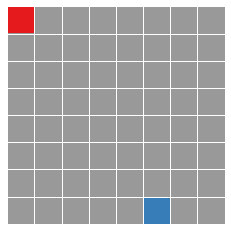

In [0]:
# np.random.seed(1)

# Training
sess = tf.InteractiveSession() # Initialize session
sess.run(tf.global_variables_initializer())

for i_ep in range(n_ep): # Loop through games
  
  # Reset map and team scores
  map, team_scores = reset(agent_dict)
  
  print('Game', i_ep, 'started.')
  # For keeping track of time
  t_start = time.time()
  t1 = time.time()
  for turn in range(max_turn):
    turn_queue = action_queue(agent_dict) # Order of taking actions this turn

    # End of game (last man standing)
    if len(turn_queue) == 1:
      print("David", turn_queue[0], "is the lone survivor.")
      print("Team Scores:", team_scores)
      print("Game", i_ep, "ended on turn", turn-1)#, "-----------------------")
      break
    
    # Target q network update
    if turn % target_copy_freq:
      for ind, agnt in agent_dict.items():
        # Get all the variables in the Q primary network.
        q_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="Q_primary"+str(ind))
        # Get all the variables in the Q target network.
        q_target_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="Q_target"+str(ind))
        assert len(q_vars) == len(q_target_vars)

        # Hard update
        sess.run([v_t.assign(v) for v_t, v in zip(q_target_vars, q_vars)])


    # Loop through alive agents
    for j in turn_queue:
      # Agent object
      current_agent = agent_dict[j]
      
      # If dead in queue, pass turn.
      if not current_agent.alive():
        continue;

      state = current_agent.observe(map)    # State formation
      
      # Action selection
      q_values = sess.run(current_agent.DQN.outputs,
                          feed_dict = {current_agent.DQN.inputs:np.reshape(state,[1, state.size])}) # Get q-values from the network
      p_values = tf.exp(beta * q_values)/tf.reduce_sum(tf.exp(beta * q_values)) # Boltzmann probabilities
      action = np.random.choice(np.arange(4),p=np.squeeze(p_values.eval()))

      dir = get_dir(action) # Convert to direction

      # Take the action
      personal_point,team_point = current_agent.act(dir, turn, quiet=False)
      
      # New state
      state_new = current_agent.observe(map)

      # Immediate reward
      reward = sigma * personal_point + (1-sigma) * team_point
      
      # Add experience to memory: [s,a,r,s']
      current_agent.memory.add([state, action, reward, state_new])

      # Update Q-function
      if not current_agent.tenure:
        batch = current_agent.memory.sample(batch_size)
        actual_batch_size = len(batch)

        # Separate out s,a,r,s' from the batch which is a list of lists
        states = np.array([item[0] for item in batch])
        actions = np.array([item[1] for item in batch])
        rewards = np.array([item[2] for item in batch])
        next_states = np.array([item[3] for item in batch])

        # Reshape (-1 automatically determines the appropriate length)
        states = np.reshape(states,[actual_batch_size, -1])
        actions = np.reshape(actions,[actual_batch_size, -1])
        rewards = np.reshape(rewards,[actual_batch_size, -1])
        next_states = np.reshape(next_states,[actual_batch_size, -1])
        
        # Q-value of the next state
        Q_next = sess.run(current_agent.DQN_target.outputs,
                          feed_dict = {current_agent.DQN_target.inputs:next_states})
        Q_next_max = np.max(Q_next,axis=1,keepdims=True) # We want to apply np.max() to Q_next
        
        target_Qs = rewards + gamma * Q_next_max

        loss, _ = sess.run([current_agent.DQN.loss, current_agent.DQN.optimizer],
                            feed_dict={current_agent.DQN.inputs: states,
                                       current_agent.DQN.target_Q: target_Qs,
                                       current_agent.DQN.actions: actions})
        
        '''
        # Write TF Summaries
        summary = sess.run(write_op, feed_dict={current_agent.DQN.inputs: states,
                                           current_agent.DQN.target_Q: target_Qs
                                           current_agent.DQN.actions: actions})
        writer.add_summary(summary, i_ep)
        writer.flush()
        '''
    
    # Graphics -----------------------------------------------------------------
    t2 = time.time()
    print("Runtime:", t2-t1)
    t1 = t2
    
    print("Game " + str(i_ep) + ", turn " + str(turn))
    plot_map(map)
    time.sleep(0.5)

    
    
    # Game ended without conclusion
    if turn == max_turn-1:
      print("Game did not finish.")

  t_finish = time.time()
  print("Game", i_ep, "runtime:", t_finish-t_start, "-----------------------")
  #print("Game", str(i_ep), "ended on turn", turn, "-----------------------")
    
sess.close() # Close session

In [0]:
current_agent = agent_dict[3]
len(current_agent.memory.buffer)

23